## STA 141B Final Project - California Amid COVID-19
### Qiushuang/Rachel Xu
### Date: 2021/12

## **I. Motivation**

This project intends to explore the question: How is California doing amid the COVID-19 pandemic? To approach this question with the help of data science, several datasets were gathered to conduct analysis and visualization on the pandemic situation. 

<span style="color:darkblue"> **(Grading criteria)** The 5 categories selected to grade this project are: 1, 2, 4, 5, 6. (Excluded: 3-numpy & 7-sql) 

In [35]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Code cells on/off."></form>''')

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely import wkt
import matplotlib.pyplot as plt
import plotnine as p9
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import warnings
warnings.filterwarnings('ignore')        # pandas.datetime

## **II. Visualizations and Analysis**

#### 2.1 SDI (Social Vulnerability Index)

The first dataset we will look at is from [CDC.gov](https://data.cdc.gov/Vaccinations/Vaccine-Hesitancy-for-COVID-19-County-and-local-es/q9mh-h2tw). This nation-wide dataset includes information on each county's hesitancy to vaccinate, their Social Vulnerability Index (SVI), as well as some population composition information. We filter out rows of counties that correspond to those in California and use the geographic information (county boundary) to visualize the overall state-wise vulnerability. 

In [2]:
df1 = pd.read_csv('hesitant.csv')

In [3]:
cali1 = df1[df1.State == "CALIFORNIA"].copy()
cali1.head(3)

,FIPS Code,County Name,State,Estimated hesitant,Estimated hesitant or unsure,Estimated strongly hesitant,Social Vulnerability Index (SVI),SVI Category,CVAC level of concern for vaccination rollout,CVAC Level Of Concern,...,Percent Hispanic,Percent non-Hispanic American Indian/Alaska Native,Percent non-Hispanic Asian,Percent non-Hispanic Black,Percent non-Hispanic Native Hawaiian/Pacific Islander,Percent non-Hispanic White,Geographical Point,State Code,County Boundary,State Boundary
391,6065,"Riverside County, California",CALIFORNIA,0.0690,0.1068,0.0335,0.79,High Vulnerability,0.65,High Concern,...,0.4891,0.0043,0.0632,0.0610,0.0027,0.3532,POINT (-119.662127 37.211164),CA,"MULTIPOLYGON (((-117.672439 33.870258, -117.67...","MULTIPOLYGON (((-124.136561 41.464452, -124.15..."
395,6103,"Tehama County, California",CALIFORNIA,0.0821,0.1284,0.0410,0.96,Very High Vulnerability,0.83,Very High Concern,...,0.2497,0.0139,0.0151,0.0074,0.0002,0.6834,POINT (-119.662127 37.211164),CA,"MULTIPOLYGON (((-122.371476 40.372606, -122.36...","MULTIPOLYGON (((-124.136561 41.464452, -124.15..."
400,6039,"Madera County, California",CALIFORNIA,0.0820,0.1294,0.0410,0.95,Very High Vulnerability,0.73,High Concern,...,0.5777,0.0099,0.0194,0.0307,0.0009,0.3413,POINT (-119.662127 37.211164),CA,"MULTIPOLYGON (((-120.106385 37.167153, -120.10...","MULTIPOLYGON (((-124.136561 41.464452, -124.15..."


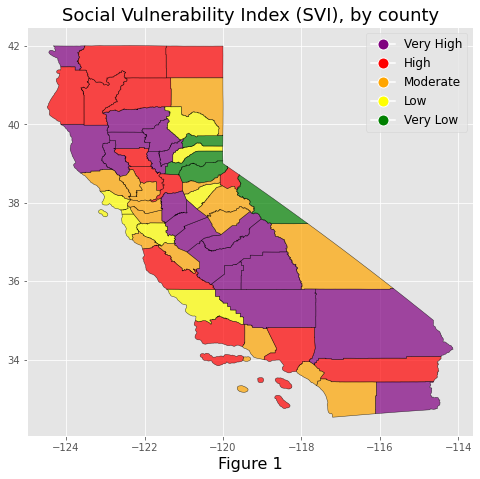

In [4]:
cali1['County Boundary'] = cali1['County Boundary'].apply(wkt.loads)
cali_geo = gpd.GeoDataFrame(cali1, geometry='County Boundary')

a = pd.DataFrame(cali_geo.groupby('SVI Category').size())   # groupby and assign colors
a["color"] = ["red","yellow","orange","purple", "green"]

cali_geo['color'] = cali_geo['SVI Category'].map(a['color'])

plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(8,8))

cali_geo.plot(ax=ax, color=cali_geo['color'], 
               alpha=0.7, edgecolor="black")
plt.title("Social Vulnerability Index (SVI), by county", 
         fontsize=18)

leg_ele = [Line2D([0], [0], marker='o',color='w', label='Very High',
                          markerfacecolor='purple', markersize=11),
           Line2D([0], [0], marker='o', color='w', label='High',
                          markerfacecolor='red', markersize=11),
           Line2D([0], [0], marker='o', color='w', label='Moderate',
                          markerfacecolor='orange', markersize=11),
          Line2D([0], [0], marker='o', color='w', label='Low',
                          markerfacecolor='yellow', markersize=11),
          Line2D([0], [0], marker='o', color='w', label='Very Low',
                          markerfacecolor='green', markersize=11)]

ax.legend(handles=leg_ele, loc="upper right", prop={"size":12})
ax.set_xlabel("Figure 1", color="black", fontsize=16)
plt.show()

From figure 1 we see the vast majority of the area of California is calssified to be vulnerable to diasters. To visualize this variable in another way, we will join the dataset to a data that contains the population information of each county in California (from [data.census.gov](https://data.census.gov/cedsci/table?text=redistricting&g=0400000US06%240500000&tid=DECENNIALPL2020.P1&hidePreview=true)). The pie chart in figure 2 suggests that, worryingly, over half of the population is highly vulnerable to disasters like a pandemic.

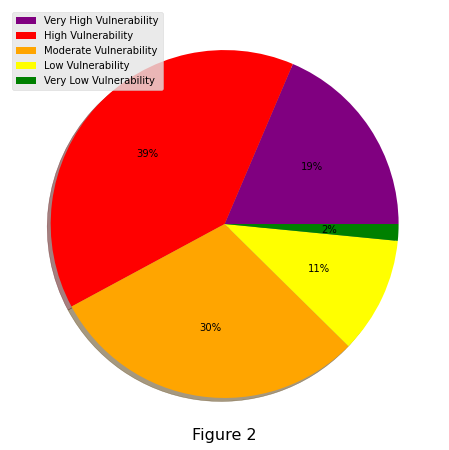

In [5]:
pop = pd.read_csv('pop.csv').iloc[1:,1:3]

bigpop = cali_geo.merge(pop, left_on="County Name", right_on="NAME")

bigpop.P1_001N = bigpop['P1_001N'].apply(int)
popsum = bigpop.groupby('SVI Category').sum()

popsum = popsum.reindex(["Very High Vulnerability", "High Vulnerability",
                         "Moderate Vulnerability", "Low Vulnerability", 
                         "Very Low Vulnerability"])

popsum.plot.pie(y='P1_001N', colors=("purple","red","orange","yellow","green"), 
                legend=True, ylabel="", labels=None, 
                autopct='%1.00f%%',shadow=True,
                figsize=(8,8),title="Breakdown of population vulnerability")
plt.title("Figure 2", y = -0.01, fontsize=16)
plt.show()

#### 2.2 Vaccination Differences

The next dataset will be requested using API provided by [data.ca.gov](https://data.ca.gov/dataset/covid-19-post-vaccination-infection-data/resource/22066d16-3465-4339-94d6-a4f1b3a91101). Using json and urllib packages, we are able to request the entire data at once. Peeking into the returned json object, we can see that this data has variables such as number of unvaccinated hospitalization/deaths, as well as the vaccinated counterparts.

With such a data set, we will consider the number of total statistic (for example, deaths) to be a sum of corresponding statistic of unvaccinated and vaccinated population. It's worth noting that this data has daily records, with dates ranging from 2021-02-01 to 2021-11-27, presumably because vaccines did not become readily available to the general public until around the start date. Although the range of analysis is confined, since the vaccinated v.s. unvaccinated differences will be researched, the way this data is set up works just fine.

In [6]:
import json
import urllib.request

url = 'https://data.ca.gov/api/3/action/datastore_search?resource_id=22066d16-3465-4339-94d6-a4f1b3a91101&limit=300'  
res = urllib.request.urlopen(url)
output = json.loads(res.read())

In [7]:
output['result']['records'][-1]       # the latest entry of record, on 2021-11-27

{'unvaccinated_hosp_per_100k': '1.20626241',
 'unvaccinated_cases_per_100k': '31.38072645',
 'vaccinated_hosp_per_100k': '0.11109656',
 'population_unvaccinated': '6383354',
 'unvaccinated_deaths': '14',
 'area': 'California',
 'unvaccinated_cases': '1836',
 'vaccinated_cases': '1023',
 'unvaccinated_hosp': '63',
 'vaccinated_deaths': '3',
 'area_type': 'State',
 'vaccinated_cases_per_100k': '4.42912504',
 'unvaccinated_deaths_per_100k': '0.29093528',
 'population_vaccinated': '25203301',
 'vaccinated_hosp': '20',
 'date': '2021-11-27',
 'vaccinated_deaths_per_100k': '0.01927185',
 '_id': 300}

One inconvienence here is that all the numeric values are recorded as strings (see below). Thus we will customize a python script to convert specified columns of any data to float, instead of manually repeating the process.

In [8]:
result1 = output['result']['records']

hosp = pd.DataFrame((js['unvaccinated_hosp_per_100k'], js['vaccinated_hosp_per_100k'], 
                     js['date']) for js in result1)
death = pd.DataFrame((js['unvaccinated_deaths_per_100k'], js['vaccinated_deaths_per_100k'], 
                     js['date']) for js in result1)
hosp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       300 non-null    object
 1   1       300 non-null    object
 2   2       300 non-null    object
dtypes: object(3)
memory usage: 7.2+ KB


In [9]:
def to_flo(df, cols):
    
    """ convert user-specified columns of a data from object to float"""
    """ input: df - data, cols - a list of numbers with non-negative size (which cols to convert)"""
    
    for i in range(len(cols)):
        df.iloc[:,cols[i]] = df.iloc[:,cols[i]].apply(float)

Before utilizing this function, we will first rename the columns of `hosp` and `death` to be something meaningful. After converting numerical columns to float, for each data, we manually add a column to be the sum of vaccinated and unvaccinated statistics. Finally, since the original data was messy with regard to the ordering of dates, we convert the date columns to be pandas datetime objects so we can sort them. 

In [10]:
names = ["unvax", "vax", "date"]
hosp.columns,death.columns = names, names            # rename columns

to_flo(hosp, [0,1])                                  # change numeric values to float
to_flo(death, [0,1])

death['t'] = death['unvax'] + death['vax']           # add column - total
hosp['t'] = hosp['unvax'] + hosp['vax']

hosp['date'] = pd.to_datetime(hosp.date)             # change date format to sort
death['date'] = pd.to_datetime(death.date)

hosp = hosp.sort_values('date')                      # sort dataframes
death = death.sort_values('date')

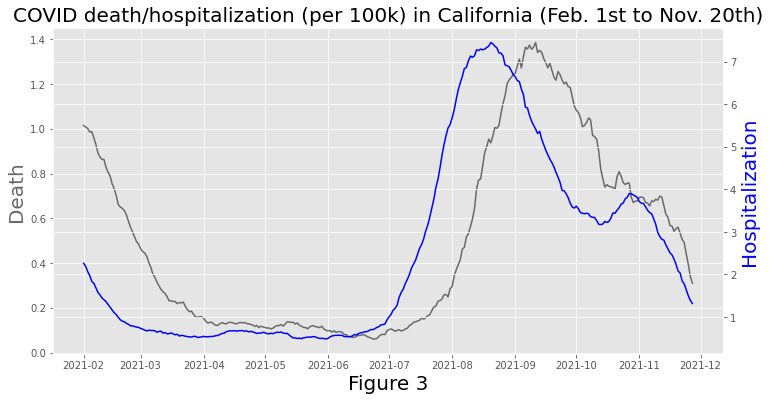

In [11]:
fig, ax = plt.subplots(figsize = (12,6))
ax2 = ax.twinx()
#ax.scatter(death.date, death.t, s=5)
ax.plot(death.date, death.t, c='dimgrey')
ax.set_ylabel('Death', color = 'dimgrey', fontsize=20)

ax2.plot(hosp.date, hosp.t, c='b')
ax2.set_ylabel('Hospitalization', color = 'b', fontsize=20)

ax.set_xlabel('Figure 3', color="black", fontsize=20)

plt.title('COVID death/hospitalization (per 100k) in California (Feb. 1st to Nov. 20th)', fontsize=20)

plt.show()

Figure 3 above use date as the x-axis, total death (per 100k) on the primary y-axis and total hospitalization (per 100k) on the secondary y-axis. Some observation made from this plot include: (1) The patterns of hospitalization and deaths cases are highly similar, with a lag/delay in time. (2) The number of both types of cases were under control after April, but encountered a huge spike staring in July. Before further investigating the reasons behind these observation, we will look at a breakdown of total statistics (into vaccinated and unvaccinated population). 

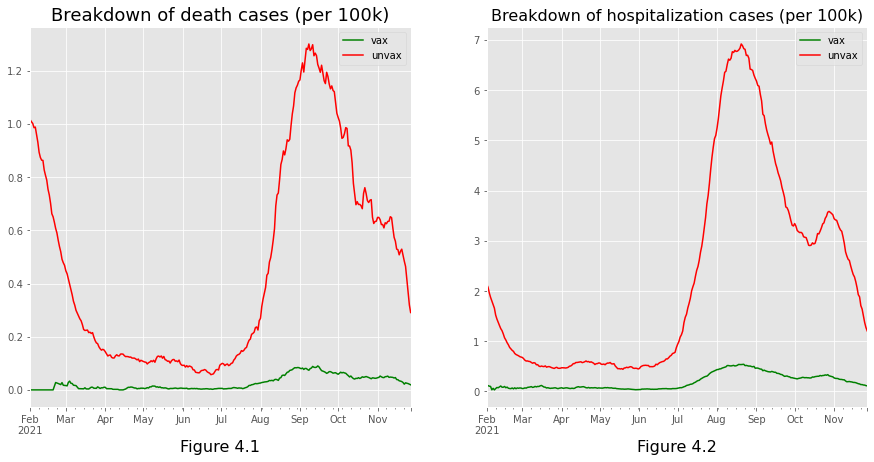

In [12]:
fig, ax = plt.subplots(figsize = (15,7), nrows=1, ncols=2)

death.plot("date", "vax", "line", ax=ax[0], color="green")
death.plot("date", "unvax", "line", ax=ax[0], color="red")
ax[0].set_title("Breakdown of death cases (per 100k)", fontdict={'fontsize':18})
ax[0].set_xlabel('Figure 4.1', color="black", fontsize=16)

hosp.plot("date", "vax", "line", ax=ax[1], color="green")
hosp.plot("date", "unvax", "line", ax=ax[1], color="red")
ax[1].set_title("Breakdown of hospitalization cases (per 100k)", fontdict={'fontsize':16})
ax[1].set_xlabel('Figure 4.2', color="black", fontsize=16)

plt.show()

Figure 4.1 and 4.2 above show, respectively, breakdown of death and hospitalization cases (into vaccinated and unvaccinated population). We can see that in each figure, the difference in magnitude of cases between the two types of population (i.e. between red and green curves) are spark. The green curves (vaccinated) is flattened, while the red curves (unvaccinated) follow the same shape of the overall curve from figure 3. That implies unvaccinated people take up the vast majority of the overall cases (both hospitalization and deaths).

#### 2.3 A different perspective

However, the spark contrasts in magnitutde masked the patterns of fluctuation in green curves. Thus we will re-group the visualizing elements by making two plots for unvaccinated and vaccinated poulation.

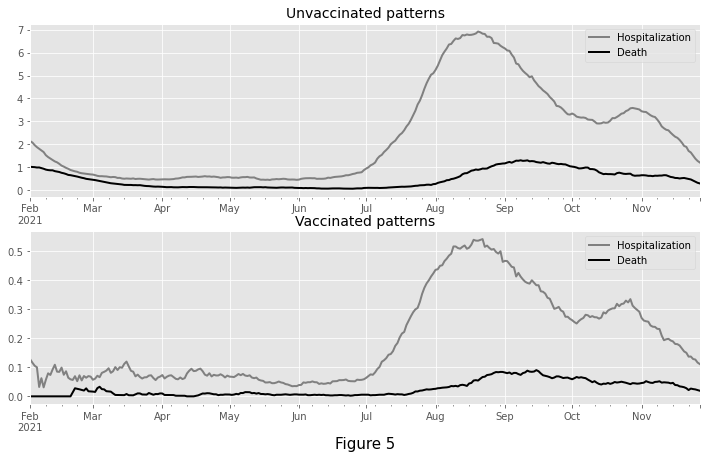

In [13]:
fig, (ax1,ax2) = plt.subplots(figsize = (12,7), nrows=2, ncols=1)

hosp.plot("date", "unvax", "line", ax=ax1, color="grey", linewidth=2)
death.plot("date", "unvax", "line", ax=ax1, color="black", linewidth=2)
ax1.legend(["Hospitalization","Death"])
ax1.set_title("Unvaccinated patterns", fontdict={'fontsize':14})
ax1.set_xlabel("")

hosp.plot("date", "vax", "line", ax=ax2, color="grey", linewidth=2)
death.plot("date", "vax", "line", ax=ax2, color="black", linewidth=2)
ax2.legend(["Hospitalization","Death"])
ax2.set_title("Vaccinated patterns", fontdict={'fontsize':14})
ax2.set_xlabel('Figure 5', color="black", fontsize=15)

plt.show()

Figure 5 reveals the similarity in patterns when we look at each type of population on their own scales. In other words, vaccinated population experiences spikes in cases in a similar fashion to unvaccinated population, just at a much smaller magnitude. Despite the similarity, vaccinated population still has smaller percentages of increase in cases than the unvaccinated counterpart.

From the observtations we can make a preliminary summary: <br /> (1) vaccination can reduce the number of cases (both hospitalization and death) to a fraction of the number of cases we would see if there was no vaccination; <br /> (2) if vaccination rates were high, the probability of medical resource depleting when situation worsens would be greatly reduced.

We will next look at the vaccine coverage in the state of california using a data from [data.ca.gov](https://data.ca.gov/dataset/covid-19-vaccine-progress-dashboard-data/resource/c020ef6b-2116-4775-b11d-9df2875096ab), which contains information about state-wise daily/cumulative number of vaccination, as well as a breakdown to each county.

In [14]:
url2 = 'https://data.ca.gov/api/3/action/datastore_search?resource_id=c020ef6b-2116-4775-b11d-9df2875096ab&limit=40000'  
res2 = urllib.request.urlopen(url2)
vax_res = json.loads(res2.read())

vax_js = vax_res['result']['records']

We convert some of the results from request to a data frame, and firstly filter out only state-wise total. Since vaccine rollout did not really happen on a large scale until spring of this year, for the sake of visualization we display the results only from 2021-02-01 on.

In [15]:
vax_df = pd.DataFrame((js['county'], js['cumulative_fully_vaccinated'], 
                       js['cumulative_at_least_one_dose'], js['administered_date']) for js in vax_js)
vax_df.columns = ['county', 'fully_vax', 'part_vax', 'date']

cali_vax = vax_df[vax_df.county == "All CA Counties"].copy()
cali_vax['date'] = pd.to_datetime(cali_vax.date)

In [16]:
day1 = cali_vax.date[cali_vax.date == '2021-02-01'].index[0]

cali_vax = cali_vax[cali_vax.index >= day1]

to_flo(cali_vax, [1,2])                           # convert from object to numeric

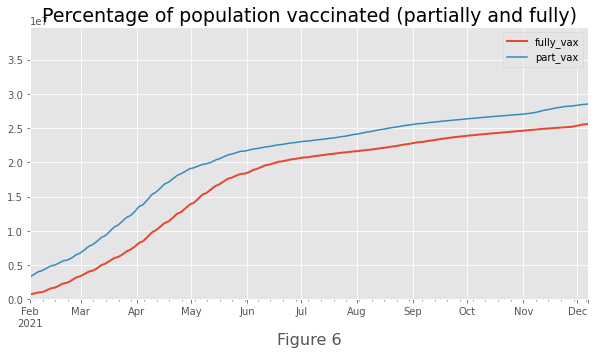

In [17]:
fig, ax = plt.subplots(figsize = (10,5))

cali_vax.plot("date", "fully_vax","line", ax=ax, linewidth=2)
cali_vax.plot("date", "part_vax", ax=ax)

ax.set_title('Percentage of population vaccinated (partially and fully)', fontsize=19)
ax.set_xlabel("Figure 6", fontsize=16)
plt.ylim(0, 39700000)
plt.show()

The y-axis of figure 6 was extended to reflect the total population of the state so we can get visual approximation of the percentage of vaccination during the time period. We can see that from February to June, the numbers grew quickly, meaning that the residents responded quickly to vaccines being newly available. The rate of growth visibly decreased from then, and up until this month (December 2021), around 80% of the population in California have received at least one dose.

#### 2.4 Vaccination as a protective measure

The growth curve of vaccination looks good, but we still need to tie the pictures together. Thus, we will return to the first API we used to obtain information about COVID cases to compare with daily vaccination, which we will obtain by using `diff()` on the cumulative column of vaccination data. We filter only the rows from 2021-02-01 on, for aforementioned reasons.

In [18]:
vax2 = pd.DataFrame((js['county'], js['cumulative_fully_vaccinated'], 
                     js['administered_date']) for js in vax_js)
to_flo(vax2, [1])                        # convert count to numeric
vax2.columns = ['county', 'cumulative', 'date']
vax2['date'] = pd.to_datetime(vax2.date) # convert date to dates

In [19]:
vax21 = vax2[vax2.county == "All CA Counties"].copy().sort_values('date')

vax21['daily'] = vax21.cumulative.diff()              # find daily from cumulative
to_flo(pop,[1])                                       # convert population to numeric 
vax21['per100k'] = vax21.daily*100000/pop.sum()[1]    # find daily per100k

vax21 = vax21[vax21.date > pd.datetime(2021,1,31)]    # from 02/01

In [20]:
case = pd.DataFrame((js['vaccinated_cases_per_100k'], js['unvaccinated_cases_per_100k'],
                     js['date']) for js in result1).copy()
case.columns= ['case1', 'case2', 'date']
case['date'] = pd.to_datetime(case.date)

to_flo(case, [0,1])
case['totalcase'] = case.case1 + case.case2

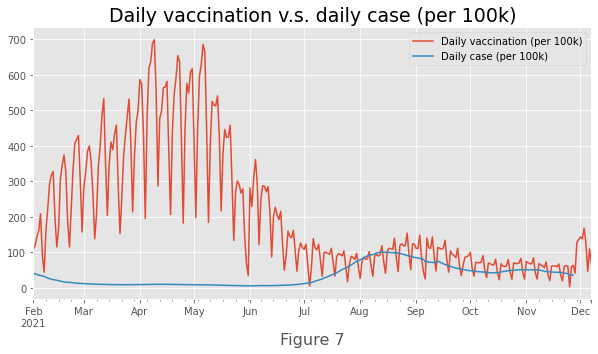

In [21]:
fig, ax = plt.subplots(figsize = (10,5))

vax21.plot("date", "per100k",'line', ax=ax)
case.plot("date", "totalcase", ax=ax)

ax.set_title('Daily vaccination v.s. daily case (per 100k)', fontsize=19)
ax.legend(['Daily vaccination (per 100k)', 'Daily case (per 100k)'])
ax.set_xlabel("Figure 7", fontsize=16)
plt.show()

Figure 7 suggests demonstrates the relationship between daily count of vaccination and daily cases of COVID infection (both per 100k). We can see that when number of vaccines administered is high (March to June), the number of cases are low. When the vaccination declined (July to August), COVID cases began to increase. More subtle observations can be made from September and October, when there was a slight decline in vaccination; the number of daily infections also subsequently increased on a small scale.

Next, we will take a closer look at hospital availability with a dataset from [data.ca.gov](https://data.ca.gov/dataset/covid-19-hospital-data1/resource/0d9be83b-5027-41ff-97b2-6ca70238d778), which contains information of daily counts of hospitalized patient who are confirmed or suspected to have COVID, number of hospital beds, available beds in ICU, etc. All these variables are recorded daily and available for counties in California, ranging from 2020-03-29 to 2021-12-05.

We would like to know to what extend vaccination coverage helps to prevent depletion of medical resources, and we will gain some insight by visualizing the number of vaccines adminstered is related to the availability of ICU beds, state-wise (group by dates and sum across all counties).

In [22]:
icu = pd.read_csv('icu.csv')
icu['date'] = pd.to_datetime(icu.todays_date)              
icu.head(3)

,county,todays_date,hospitalized_covid_confirmed_patients,hospitalized_suspected_covid_patients,hospitalized_covid_patients,all_hospital_beds,icu_covid_confirmed_patients,icu_suspected_covid_patients,icu_available_beds,date
0,Yolo,2020-03-29,2.0,3.0,NaN,NaN,1.0,1.0,0.0,2020-03-29
1,Amador,2021-10-01,11.0,0.0,11.0,53.0,5.0,0.0,0.0,2021-10-01
2,Tuolumne,2020-03-29,1.0,5.0,NaN,NaN,0.0,0.0,0.0,2020-03-29


In [23]:
gb = icu.groupby(['date']).sum().reset_index()

gb.rename(columns={"icu_available_beds": "ICU"}, inplace=True)

to_flo(gb, [7]); gb['date'] = pd.to_datetime(gb.date); gb['ratio'] = gb.ICU/gb.all_hospital_beds

gb = gb[gb.date > pd.datetime(2021,1,31)]

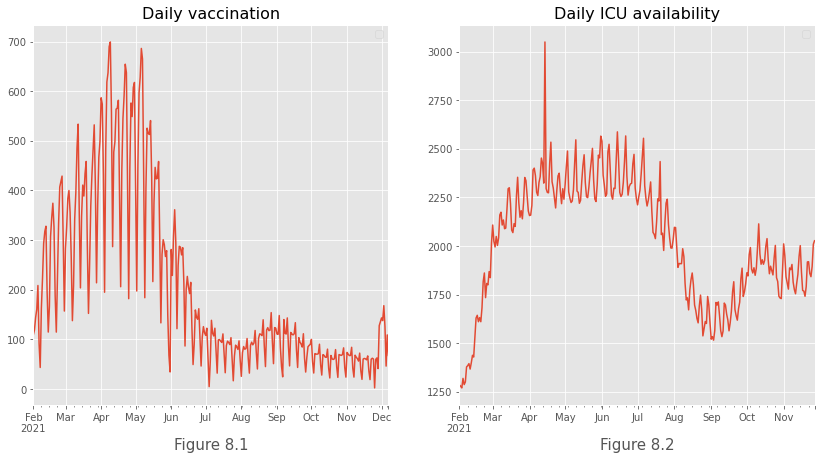

In [24]:
fig, (ax1,ax2) = plt.subplots(figsize = (14,7),ncols=2,nrows=1)

vax21.plot("date", "per100k",'line', ax=ax1)
ax1.set_title('Daily vaccination', fontsize=16)
ax2.set_title('Daily ICU availability', fontsize=16)

gb.plot("date", "ICU", ax=ax2)
ax1.legend(''); ax1.set_xlabel("Figure 8.1", fontsize=15)
ax2.legend(''); ax2.set_xlabel("Figure 8.2", fontsize=15)

plt.show()

Figure 8.1 and 8.2 show, respectively, the fluctuation of state-wise daily vaccination and ICU beds available. The similarity between the patterns is quite obvious at first glance, with a slight delay in time. For example, the count of vaccinated persons declined from May to July, and from July to September, the amount of beds in ICU available also dropped. When the preceding variable increased from August to September, the availability improved in September to October.

From these observations, we can summarize that:  <br /> (1) Increasing the amount of vaccines administered will very likely help to prevent the depletion or inaccessibility of medical resources;<br /> (2) If we were interested in forecasting the availability of certain medical resources to be prepared, it will help to look into vaccine-related variables.

#### 2.5 Vaccination as a preventive measure

Finally, we will use a geographical visualization to evaluate the effectiveness of vaccine as a protective measure. Vaccines are not designed to eliminate a virus or to prevent all those that received them from infection, but to prevent an influx of infected so huge that medical resources cannot go to everyone in need. Earlier this year (2021), there was a huge spike of spread during late summer, several months after vaccines rollout. Using regional vaccine administration and hospitalization information, we will compared the **preparedness** (vaccination coverage) of each county and the amount of **hospitalization they witnessed during the spike**.

The variables we will use to quantify these two measures will be selected from different time periods. The **preparedness** will be based on cumulative vaccination coverage up until the spike, which started in July 2021. The **hospitalization** will be calculated during the spike (July to September). More specifically, the preparedness variable for each county will be <span style="color:darkgreen"> **the cumulative vaccination per 100k of population on 2021-06-31** </span>. The hospitalization variable for each county will be <span style="color:darkgreen"> **the average number of hospitalization per 100k of population during the spike** </span> (from 2021-07-01 to 2021-10-01).

The variables themselves will be calculated from vaccination and hospital data respectively, then joined with the SDI data, which contains geographic information; the output data will then be joined with population data for the population information.

In [26]:
vax_prep = vax2[vax2.date == pd.datetime(2021,6,30)][4:]                             # preparedness data   (A)

spike_hosp = icu[(icu.date >= pd.datetime(2021,7,1)) & (icu.date <= pd.datetime(2021,10,1))][4:]
spike_hosp = spike_hosp.groupby('county').mean()                                     # hospitalization data (B)

In [27]:
vax_hosp = vax_prep.merge(spike_hosp, on="county")[0:]                               # merge A and B

for i in range(vax_hosp.shape[0]):
    vax_hosp['county'].iloc[i] = vax_hosp.county.iloc[i] + " County, California"     # to match geodata (C)

final = vax_hosp.merge(cali1, left_on="county", right_on="County Name")              # merge (A+B) and C

In [28]:
final1 = final.merge(pop, left_on="County Name", right_on="NAME")                    # merge (A+B+C) and D

final1['vax_per100k'] = final1.cumulative*100000/final1.P1_001N                      # add desired variables
final1['hosp_per100k'] = final1.hospitalized_covid_confirmed_patients*100000/final1.P1_001N

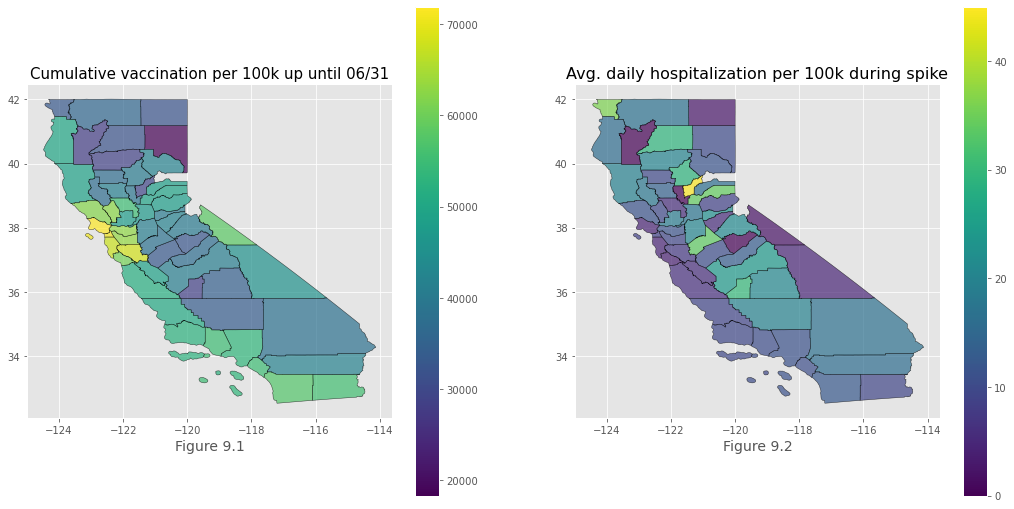

In [29]:
final1 = gpd.GeoDataFrame(final1, geometry='County Boundary')                        # convert to geo data

fig, (ax1,ax2) = plt.subplots(figsize=(18,9),ncols=2,nrows=1)

final1.plot(ax=ax1, column='vax_per100k', alpha=0.7, edgecolor="black", legend=True)
ax1.set_title('Cumulative vaccination per 100k up until 06/31', fontsize=15)
ax1.set_xlabel('Figure 9.1', fontsize=14)

final1.plot(ax=ax2, column='hosp_per100k', alpha=0.7, edgecolor="black", legend=True)
ax2.set_title('Avg. daily hospitalization per 100k during spike', fontsize=16)
ax2.set_xlabel('Figure 9.2', fontsize=14)

plt.show()

Figure 9.1 and 9.2 provide a snapshot of California at different timestamps. Right before the spike this late summer, the vaccination coverage can be seen on fig 9.1. When the spike happened, the hospitalization situation can be seen on fig 9.2. When we compare them, we can see that counties that had higher number of vaccination per 100k population, turned out to have less hospitalization cases (per 100k) during the spike.

Furthermore, the dataframe used to obtain the maps can be easily modified and expanded. For example, if we wanted to look at daily availability of beds instead of average daily hospitalization, that variable of interest can be added to the data and a similar visualization to figure 9.1 and 9.2 can be achieved. 


## **III. Summary and Conclusion**

Finally, through various visualization with data regarding different aspects of the pandemic, we have come to the conclusion that California did a decent job flattening the curve before the late summer spike hit. By closely examining the difference between vaccinated and unvaccinated group, we saw that this specific spike had a similar effect on both groups, but the former group still was only impacted on a much larger scale. The observation was further confirmed when we look at the picture from county level: those areas that stay prepared and had higher vaccination coverage did better when the situation worsened.

Although, we are also reminded that as time progresses and the virus mutates, new challenges continue to emerge. Regarding the spike during late summer 2021, it's worthy to further investigate the situation so we can stay prepared in the future. In the time of uncertainties like this, it is crucial that we continue to look for more solutions.